In [4]:
from tabula import read_pdf

In [529]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import poisson,skellam

from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import OneHotEncoder

In [1231]:
# Reading data into a DataFrame
df = read_pdf('train - train.pdf', pages="all")

# Cleaning the data

In [1232]:
# Looping through data frames in list df and sorting out headings and rows. This is a data cleaning phase and manipulating 
# data into an easier to use format

for i in range(1,len(df)):
    df[i].loc[-1] = df[i].columns
    df[i] = df[i].sort_index().reset_index(drop=True)
    df[i].columns = df[0].columns

In [1233]:
df_train = pd.DataFrame()

In [1234]:
df_train = pd.concat(df, ignore_index = True)

In [1235]:
# Removing Null data
df_train = df_train[df_train['Home_Goals'] != 'NULL']
# Converting all dates to datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [1236]:
# Converting all erronous int columns to ints
for i in df_train.columns[5:9]:
    df_train[i] = df_train[i].astype('float')
    df_train[i] = df_train[i].astype('int')

In [1237]:
# Calculate total corners from Home+Away
df_train['Total_Corners'] = df_train['Home_Corners'] + df_train['Away_Corners']

In [1238]:
# Creating Regression Variables from the date, month and year
df_train['Month'] = df_train['Date'].dt.month 
df_train['Year'] = df_train['Date'].dt.year

In [1239]:
# Converting LeagueID, HomeTeamId and AwayTeamId into strings so to use label encoding
df_train[['LeagueId', 'HomeTeamId', 'AwayTeamId']] = df_train[['LeagueId', 'HomeTeamId', 'AwayTeamId']].astype('str')

In [1240]:
df_train

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,Month,Year
0,2826,793,2005-02-04,410,908,2,0,15,1,16,2,2005
1,2827,793,2005-02-04,338,597,3,2,3,6,9,2,2005
2,2828,793,2005-02-04,1364,246,2,3,13,2,15,2,2005
3,2829,793,2005-02-04,1088,1397,1,0,2,5,7,2,2005
4,2830,793,2005-02-04,830,1412,2,3,3,6,9,2,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
23825,307623,800,2010-12-18,1326,1399,1,0,4,5,9,12,2010
23826,307624,800,2010-12-18,944,8291,2,1,3,4,7,12,2010
23827,307625,800,2010-12-18,4704,4705,4,0,4,4,8,12,2010
23828,307626,800,2010-12-18,2113,250,1,1,5,5,10,12,2010


# Applying Poission Distribution

In [373]:
corner_mean = df_train.mean()[5:7]

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [374]:
corner_mean

Home_Corners    5.725842
Away_Corners    4.493493
dtype: float64

In [1242]:
df_train[['Away_Corners', 'Home_Corners']].var()

Away_Corners    6.276667
Home_Corners    8.087925
dtype: float64

In [375]:
# probability of draw in corners between home and away team
skellam.pmf(0.0,  corner_mean[0],  corner_mean[1])

0.11777373004246432

In [376]:
# probability of home team having one more corner
skellam.pmf(1,  corner_mean[0],  corner_mean[1])

0.12621323935575812

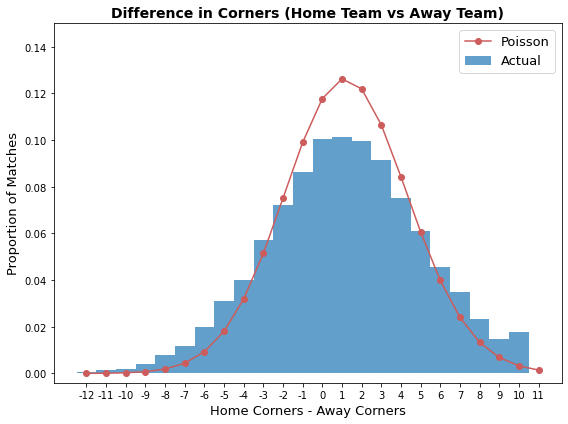

In [1252]:
skellam_pred = [skellam.pmf(i,  corner_mean[0],  corner_mean[1]) for i in range(-12,12)]

plt.figure(figsize=(8,6))
plt.hist(df_train['Home_Corners'].values - df_train['Away_Corners'].values, range(-12,12), 
         alpha=0.7, label='Actual',density=True,)

plt.plot([i+0.5 for i in range(-12,12)], skellam_pred,
                  linestyle='-', marker='o',label="Poisson", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-12,12)],[i for i in range(-12,12)])
plt.xlabel("Home Corners - Away Corners",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Corners (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.15])
plt.tight_layout()


plt.savefig('Poisson Distirbution.png')
plt.show()


In [1255]:
df_train

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,Month,Year
0,2826,793,2005-02-04,410,908,2,0,15,1,16,2,2005
1,2827,793,2005-02-04,338,597,3,2,3,6,9,2,2005
2,2828,793,2005-02-04,1364,246,2,3,13,2,15,2,2005
3,2829,793,2005-02-04,1088,1397,1,0,2,5,7,2,2005
4,2830,793,2005-02-04,830,1412,2,3,3,6,9,2,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
23825,307623,800,2010-12-18,1326,1399,1,0,4,5,9,12,2010
23826,307624,800,2010-12-18,944,8291,2,1,3,4,7,12,2010
23827,307625,800,2010-12-18,4704,4705,4,0,4,4,8,12,2010
23828,307626,800,2010-12-18,2113,250,1,1,5,5,10,12,2010


In [658]:
goal_model_data = pd.concat([df_train[['HomeTeamId','AwayTeamId','Home_Corners']].assign(home=1).rename(
            columns={'HomeTeamId':'team', 'AwayTeamId':'opponent','Home_Corners':'corners'}),
           df_train[['AwayTeamId','HomeTeamId','Away_Corners']].assign(home=0).rename(
            columns={'AwayTeamId':'team', 'HomeTeamId':'opponent','Away_Corners':'corners'})])

In [1254]:
goal_model_data

,team,opponent,corners,home
0,410,908,15,1
1,338,597,3,1
2,1364,246,13,1
3,1088,1397,2,1
4,830,1412,3,1
...,...,...,...,...
23825,1399,1326,5,0
23826,8291,944,4,0
23827,4705,4704,4,0
23828,250,2113,5,0


In [659]:
poisson_model = smf.glm(formula="corners ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                corners   No. Observations:                47644
Model:                            GLM   Df Residuals:                    46983
Model Family:                 Poisson   Df Model:                          660
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1096e+05
Date:                Wed, 30 Dec 2020   Deviance:                       63530.
Time:                        22:51:10   Pearson chi2:                 6.11e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4255      0.051     28.135      0.000       1.326       1.525
team[T.1016]         0.1526      0.038      4.039      0.000       0.079       0.227
team[T.1025]        -0.1014      0.060     -1.687      0.092      -0.219       0.016
team[T.1026]         0.1958      0.037      5.290      0.000       0.123       0.268
team[T.1028]         0.0624      0.040      1.569      0.117      -0.016       0.140
team[T.1031]        -0.0649      0.046     -1.406      0.160      -0.155       0.026
team[T.1034]        -0.0123      0.040     -0.310      0.757      -0.090       0.065
team[T.1035]         0.1098      0.042      2.633      0.008       0.028       0.192
team[T.1040]         0.1899      0.041      4.632      0.000       0.110       0.270
team[T.1043]         0.1979      0.043      4.615      0.000       0.114       0.282
team[T.1048]        -0.0439      0.060     -0.726      0.468      -0.162       0.075
team[T.1049]         0.1329      0.039      3.429      0.001       0.057       0.209
team[T.1051]         0.0770      0.057      1.358      0.175      -0.034       0.188
team[T.1052]        -0.0869      0.048     -1.816      0.069      -0.181       0.007
team[T.1056]         0.0079      0.041      0.194      0.846      -0.072       0.088
team[T.1061]        -0.0926      0.044     -2.121      0.034      -0.178      -0.007
team[T.1071]        -0.0097      0.043     -0.226      0.821      -0.094       0.074
team[T.1072]         0.0535      0.042      1.258      0.208      -0.030       0.137
team[T.1073]         0.3939      0.048      8.284      0.000       0.301       0.487
team[T.1076]        -0.0820      0.057     -1.437      0.151      -0.194       0.030
team[T.1079]        -0.0283      0.045     -0.630      0.529      -0.116       0.060
team[T.1088]         0.0763      0.038      1.987      0.047       0.001       0.152
team[T.1089]        -0.1324      0.053     -2.508      0.012      -0.236      -0.029
team[T.1090]         0.0642      0.039      1.648      0.099      -0.012       0.140
team[T.1092]         0.1219      0.041      2.945      0.003       0.041       0.203
team[T.1096]        -0.0155      0.043     -0.358      0.721      -0.101       0.070
team[T.1098]         0.0434      0.039      1.103      0.270      -0.034       0.120
team[T.1107]        -0.0364      0.045     -0.811      0.417      -0.124       0.052
team[T.1108]         0.0118      0.050      0.234      0.815      -0.087       0.110
team[T.1116]         0.0757      0.051      1.499      0.134      -0.023       0.175
team[T.1117]         0.1354      0.041      3.340      0.001       0.056       0.215
team[T.1118]         0.4031      0.040     10.180      0.000       0.325       0.481
team[T.1119]        -0.3088      0.101     -3.069      0.002      -0.506      -0.112
team[T.1121]        -0.

In [1253]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                corners   No. Observations:                47644
Model:                            GLM   Df Residuals:                    46983
Model Family:                 Poisson   Df Model:                          660
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1096e+05
Date:                Fri, 01 Jan 2021   Deviance:                       63530.
Time:                        22:44:55   Pearson chi2:                 6.11e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4255      0.051     28.135      0.000       1.326       1.525
team[T.1016]         0.1526      0.038      4.039      0.000       0.079       0.227
team[T.1025]        -0.1014      0.060     -1.687      0.092      -0.219       0.016
team[T.1026]         0.1958      0.037      5.290      0.000       0.123       0.268
team[T.1028]         0.0624      0.040      1.569      0.117      -0.016       0.140
team[T.1031]        -0.0649      0.046     -1.406      0.160      -0.155       0.026
team[T.1034]        -0.0123      0.040     -0.310      0.757      -0.090       0.065
team[T.1035]         0.1098      0.042      2.633      0.008       0.028       0.192
team[T.1040]         0.1899      0.041      4.632      0.000       0.110       0.270
team[T.1043]         0.1979      0.043      4.615      0.000       0.114       0.282
team[T.1048]        -0.0439      0.060     -0.726      0.468      -0.162       0.075
team[T.1049]         0.1329      0.039      3.429      0.001       0.057       0.209
team[T.1051]         0.0770      0.057      1.358      0.175      -0.034       0.188
team[T.1052]        -0.0869      0.048     -1.816      0.069      -0.181       0.007
team[T.1056]         0.0079      0.041      0.194      0.846      -0.072       0.088
team[T.1061]        -0.0926      0.044     -2.121      0.034      -0.178      -0.007
team[T.1071]        -0.0097      0.043     -0.226      0.821      -0.094       0.074
team[T.1072]         0.0535      0.042      1.258      0.208      -0.030       0.137
team[T.1073]         0.3939      0.048      8.284      0.000       0.301       0.487
team[T.1076]        -0.0820      0.057     -1.437      0.151      -0.194       0.030
team[T.1079]        -0.0283      0.045     -0.630      0.529      -0.116       0.060
team[T.1088]         0.0763      0.038      1.987      0.047       0.001       0.152
team[T.1089]        -0.1324      0.053     -2.508      0.012      -0.236      -0.029
team[T.1090]         0.0642      0.039      1.648      0.099      -0.012       0.140
team[T.1092]         0.1219      0.041      2.945      0.003       0.041       0.203
team[T.1096]        -0.0155      0.043     -0.358      0.721      -0.101       0.070
team[T.1098]         0.0434      0.039      1.103      0.270      -0.034       0.120
team[T.1107]        -0.0364      0.045     -0.811      0.417      -0.124       0.052
team[T.1108]         0.0118      0.050      0.234      0.815      -0.087       0.110
team[T.1116]         0.0757      0.051      1.499      0.134      -0.023       0.175
team[T.1117]         0.1354      0.041      3.340      0.001       0.056       0.215
team[T.1118]         0.4031      0.040     10.180      0.000       0.325       0.481
team[T.1119]        -0.3088      0.101     -3.069      0.002      -0.506      -0.112
team[T.1121]        -0.

In [663]:
def simulate_match(foot_model, homeTeam, awayTeam, max_corners=25):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_corners+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))


# Applying the Model to Test Data Set

In [728]:
# Reading data into a DataFrame
df = read_pdf('test - test.pdf', pages="all")

In [729]:
# Looping through data frames in list df and sorting out headings and rows. This is a data cleaning phase and manipulating 
# data into an easier to use format

for i in range(1,len(df)):
    df[i].loc[-1] = df[i].columns
    df[i] = df[i].sort_index().reset_index(drop=True)
    df[i].columns = df[0].columns

In [730]:
df_test = pd.DataFrame()

In [731]:
df_test = pd.concat(df, ignore_index = True)

In [732]:
df_test = df_test.rename(columns={"Unnamed: 0":"Total Corners"})

In [1008]:
# Converting LeagueID, HomeTeamId and AwayTeamId into strings so to use label encoding
df_test[['HomeTeamId', 'AwayTeamId']] = df_train[['HomeTeamId', 'AwayTeamId']].astype('str')
df_test['Line'] = df_test['Line'].astype('float')

In [1009]:
df_test

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Total Corners,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,01/04/2011,342,694,9.5,1.79,1.8,9.56478,0.513419,0.123896,0.362685,NaN,NaN
1,2,741,01/04/2011,1424,270,11.5,1.92,2,11.1805,0.557730,0.111063,0.331204,NaN,NaN
2,3,729,01/04/2011,691,1137,10.5,1.97,1.87,10.512,0.395726,0.123534,0.480739,NaN,NaN
3,4,729,01/04/2011,787,808,11.0,2.075,1.77,10.842,0.478883,0.119241,0.401874,NaN,NaN
4,5,741,01/04/2011,784,1117,12.0,2.02,1.86,10.9382,0.586650,0.108796,0.304548,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,22/05/2011,1211,1118,10.5,1.95,1.961,9.99798,0.490407,0.114068,0.395471,NaN,NaN
337,338,795,22/05/2011,1116,876,10.0,1.92,1.909,9.78759,0.490407,0.114068,0.395471,NaN,NaN
338,339,801,22/05/2011,1223,771,10.0,2.02,1.84,10.2526,0.490407,0.114068,0.395471,NaN,NaN
339,340,801,22/05/2011,238,570,10.5,2.02,1.9,10.6446,0.490407,0.114068,0.395471,NaN,NaN


In [987]:
df_test

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Total Corners,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,01/04/2011,342,694,9.5,1.79,1.8,9.56478,NaN,NaN,NaN,NaN,NaN
1,2,741,01/04/2011,1424,270,11.5,1.92,2,11.1805,NaN,NaN,NaN,NaN,NaN
2,3,729,01/04/2011,691,1137,10.5,1.97,1.87,10.512,NaN,NaN,NaN,NaN,NaN
3,4,729,01/04/2011,787,808,11,2.075,1.77,10.842,NaN,NaN,NaN,NaN,NaN
4,5,741,01/04/2011,784,1117,12,2.02,1.86,10.9382,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,22/05/2011,1211,1118,10.5,1.95,1.961,9.99798,NaN,NaN,NaN,NaN,NaN
337,338,795,22/05/2011,1116,876,10,1.92,1.909,9.78759,NaN,NaN,NaN,NaN,NaN
338,339,801,22/05/2011,1223,771,10,2.02,1.84,10.2526,NaN,NaN,NaN,NaN,NaN
339,340,801,22/05/2011,238,570,10.5,2.02,1.9,10.6446,NaN,NaN,NaN,NaN,NaN


In [1012]:
for i,j in df_test.iterrows():
    
    home_corners = poisson_model.predict(pd.DataFrame(data={'team': j['HomeTeamId'], 'opponent': j['AwayTeamId'],
                                       'home':1},index=[1]))
    away_corners = poisson_model.predict(pd.DataFrame(data={'team': j['AwayTeamId'], 'opponent': j['HomeTeamId'],
                                       'home':0},index=[1]))
    
    df_test['Total Corners'].iloc[i] = float((home_corners + away_corners).values)
    
    prob_matrix = simulate_match(poisson_model, j['HomeTeamId'], j['AwayTeamId'], max_corners=20)
    
    line = j['Line']
    const = 10
    
    if (line - int(line) == 0): # Integer Lines - (Ability to Push Bet)
        line = round(j['Line'])
        df_test['P(Under)'].iloc[i]  = np.sum(np.triu(np.fliplr(prob_matrix), (line+1 - (line-const)*2)))
        df_test['P(At)'].iloc[i]  = np.sum(np.diag(np.fliplr(prob_matrix), line - (line-const)*2))
        df_test['P(Over)'].iloc[i]  = np.sum(np.tril(np.fliplr(prob_matrix), (line-1 - (line-const)*2)))
        
    else: # None Integer Values - 
        line = round(j['Line'])
        df_test['P(Under)'].iloc[i]  = np.sum(np.triu(np.fliplr(prob_matrix), line+1 - (line-const)*2))
        df_test['P(At)'].iloc[i]  = 0
        df_test['P(Over)'].iloc[i]  = np.sum(np.tril(np.fliplr(prob_matrix), line - (line-const)*2))
    

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

In [1013]:
df_test

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Total Corners,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,01/04/2011,342,694,9.5,1.79,1.8,9.56478,0.513419,0.000000,0.486580,NaN,NaN
1,2,741,01/04/2011,1424,270,11.5,1.92,2,11.1805,0.557730,0.000000,0.442266,NaN,NaN
2,3,729,01/04/2011,691,1137,10.5,1.97,1.87,10.512,0.395726,0.000000,0.604273,NaN,NaN
3,4,729,01/04/2011,787,808,11.0,2.075,1.77,10.842,0.478883,0.119241,0.401874,NaN,NaN
4,5,741,01/04/2011,784,1117,12.0,2.02,1.86,10.9382,0.586650,0.108796,0.304548,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,22/05/2011,1211,1118,10.5,1.95,1.961,9.99798,0.458183,0.000000,0.541817,NaN,NaN
337,338,795,22/05/2011,1116,876,10.0,1.92,1.909,9.78759,0.484770,0.124824,0.390406,NaN,NaN
338,339,801,22/05/2011,1223,771,10.0,2.02,1.84,10.2526,0.426755,0.124718,0.448524,NaN,NaN
339,340,801,22/05/2011,238,570,10.5,2.02,1.9,10.6446,0.380291,0.000000,0.619707,NaN,NaN


In [1299]:
df_betting = df_test[['Over', 'Under']]
df_betting['P(U/A)'] = df_test['P(Under)'] + df_test['P(At)']
df_betting['P(O/A)'] = df_test['P(Over)'] + df_test['P(At)']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1300]:
df_betting

,Over,Under,P(U/A),P(O/A)
0,1.79,1.8,0.513419,0.486580
1,1.92,2,0.557730,0.442266
2,1.97,1.87,0.395726,0.604273
3,2.075,1.77,0.598124,0.521116
4,2.02,1.86,0.695445,0.413343
...,...,...,...,...
336,1.95,1.961,0.458183,0.541817
337,1.92,1.909,0.609594,0.515230
338,2.02,1.84,0.551473,0.573242
339,2.02,1.9,0.380291,0.619707


In [1301]:
df_betting['Over'] = df_betting['Over'].astype('float')
df_betting['Under'] = df_betting['Under'].astype('float')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1302]:
df_betting['EV_U'] = ''
df_betting['EV_O'] = ''
df_betting['Bet'] = ''
df_betting['Best_EV'] = ''
df_betting['Bet_odds'] = ''
df_betting['Bet_prob'] = ''

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [1303]:
df_betting

,Over,Under,P(U/A),P(O/A),EV_U,EV_O,Bet,Best_EV,Bet_odds,Bet_prob
0,1.790,1.800,0.513419,0.486580,,,,,,
1,1.920,2.000,0.557730,0.442266,,,,,,
2,1.970,1.870,0.395726,0.604273,,,,,,
3,2.075,1.770,0.598124,0.521116,,,,,,
4,2.020,1.860,0.695445,0.413343,,,,,,
...,...,...,...,...,...,...,...,...,...,...
336,1.950,1.961,0.458183,0.541817,,,,,,
337,1.920,1.909,0.609594,0.515230,,,,,,
338,2.020,1.840,0.551473,0.573242,,,,,,
339,2.020,1.900,0.380291,0.619707,,,,,,


In [1304]:
stake = 1

for i,j in df_betting.iterrows():
    
    df_betting['EV_O'].loc[i] = (j['P(O/A)']*(j['Over']-1)*stake) - ((1-j['P(O/A)'])*stake)
    df_betting['EV_U'].loc[i] = (j['P(U/A)']*(j['Under']-1)*stake) - ((1-j['P(U/A)'])*stake)
    
    if df_betting['EV_O'].loc[i] > df_betting['EV_U'].loc[i]:
        
        df_betting['Best_EV'].loc[i] = df_betting['EV_O'].loc[i]
        df_betting['Bet'].loc[i] = 'O'
        df_betting['Bet_odds'].loc[i] = df_betting['Over'].loc[i]
        df_betting['Bet_prob'].loc[i] = df_betting['P(O/A)'].loc[i]
        
    else:
        
        df_betting['Best_EV'].loc[i] = df_betting['EV_U'].loc[i]
        df_betting['Bet'].loc[i] = 'U'
        df_betting['Bet_odds'].loc[i] = df_betting['Under'].loc[i]
        df_betting['Bet_prob'].loc[i] = df_betting['P(U/A)'].loc[i]

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A v

In [1305]:
df_betting

,Over,Under,P(U/A),P(O/A),EV_U,EV_O,Bet,Best_EV,Bet_odds,Bet_prob
0,1.790,1.800,0.513419,0.486580,-0.0758453,-0.129022,U,-0.0758453,1.8,0.513419
1,1.920,2.000,0.557730,0.442266,0.115461,-0.150849,U,0.115461,2,0.55773
2,1.970,1.870,0.395726,0.604273,-0.259992,0.190418,O,0.190418,1.97,0.604273
3,2.075,1.770,0.598124,0.521116,0.0586797,0.0813152,O,0.0813152,2.075,0.521116
4,2.020,1.860,0.695445,0.413343,0.293529,-0.165046,U,0.293529,1.86,0.695445
...,...,...,...,...,...,...,...,...,...,...
336,1.950,1.961,0.458183,0.541817,-0.101504,0.0565426,O,0.0565426,1.95,0.541817
337,1.920,1.909,0.609594,0.515230,0.163715,-0.0107585,U,0.163715,1.909,0.609594
338,2.020,1.840,0.551473,0.573242,0.0147111,0.157949,O,0.157949,2.02,0.573242
339,2.020,1.900,0.380291,0.619707,-0.277447,0.251809,O,0.251809,2.02,0.619707


In [1306]:
sum_probs = (1 - df_betting['Bet_prob'].sum())
sum_payoff = 1 - (1 / (df_betting['Bet_odds'] - 1)).sum()
RR = sum_probs/sum_payoff

In [1307]:
RR

0.5626511420363608

In [1308]:
df_betting = df_betting.sort_values(by=['Best_EV'],  ascending=False)

In [1309]:
df_betting['Fraction_bet'] = ''

In [1310]:
for i in range(0,len(df_betting)):
    
    f = (df_betting['Bet_prob'].iloc[i]) - (RR/(df_betting['Bet_odds'].iloc[i] - 1))
    
    df_betting['Fraction_bet'].iloc[i] = f/8

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1311]:
df_betting

,Over,Under,P(U/A),P(O/A),EV_U,EV_O,Bet,Best_EV,Bet_odds,Bet_prob,Fraction_bet
263,1.939,1.962,0.168552,0.831428,-0.6693,0.61214,O,0.61214,1.939,0.831428,0.0290282
298,1.862,1.980,0.184819,0.815028,-0.634059,0.517582,O,0.517582,1.862,0.815028,0.0202875
286,2.087,1.800,0.280979,0.719019,-0.494237,0.500592,O,0.500592,2.087,0.719019,0.025175
23,1.860,2.000,0.748471,0.358738,0.496943,-0.332747,U,0.496943,2,0.748471,0.0232275
53,1.950,1.980,0.753369,0.353073,0.491671,-0.311508,U,0.491671,1.98,0.753369,0.0224044
...,...,...,...,...,...,...,...,...,...,...,...
262,1.890,1.964,0.487832,0.512167,-0.0418983,-0.0320035,O,-0.0320035,1.89,0.512167,-0.0150031
315,1.900,1.860,0.519892,0.480108,-0.0330012,-0.0877947,U,-0.0330012,1.86,0.519892,-0.0167942
83,1.860,1.940,0.495104,0.504895,-0.0394985,-0.0608952,U,-0.0394985,1.94,0.495104,-0.0129326
294,1.930,1.783,0.528890,0.471109,-0.0569886,-0.0907592,U,-0.0569886,1.783,0.52889,-0.0237117


In [1312]:
df_betting = df_betting[df_betting['Fraction_bet'] > 0]

In [1313]:
df_betting.to_csv('test.csv')

In [1314]:
df_betting['Bet - Amount'] = ''
tot_fract = 0
bet_tot = 341

for i in range(0, len(df_betting)):
    
    tot_fract = tot_fract + df_betting['Fraction_bet'].iloc[i]
    
    df_betting['Bet - Amount'].iloc[i] = bet_tot * df_betting['Fraction_bet'].iloc[i]
    
    if tot_fract >= 1:
        break

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [1315]:
df_betting = df_betting[~(df_betting['Bet - Amount'] == '')]

In [1316]:
df_betting = df_betting.sort_index()

In [1317]:
df_betting

,Over,Under,P(U/A),P(O/A),EV_U,EV_O,Bet,Best_EV,Bet_odds,Bet_prob,Fraction_bet,Bet - Amount
4,2.02,1.860,0.695445,0.413343,0.293529,-0.165046,U,0.293529,1.86,0.695445,0.00514999,1.75615
8,1.92,1.920,0.656414,0.466449,0.260315,-0.104418,U,0.260315,1.92,0.656414,0.00560461,1.91117
9,2.02,1.890,0.486338,0.641320,-0.0808215,0.295466,O,0.295466,2.02,0.64132,0.0112126,3.82351
14,1.92,2.000,0.347028,0.652970,-0.305945,0.253702,O,0.253702,1.92,0.65297,0.00517405,1.76435
23,1.86,2.000,0.748471,0.358738,0.496943,-0.332747,U,0.496943,2,0.748471,0.0232275,7.92059
...,...,...,...,...,...,...,...,...,...,...,...,...
321,1.99,1.903,0.696838,0.416892,0.326083,-0.170385,U,0.326083,1.903,0.696838,0.00921839,3.14347
323,1.96,1.900,0.373545,0.626444,-0.290264,0.22783,O,0.22783,1.96,0.626444,0.00504359,1.71986
329,1.88,2.000,0.632809,0.491282,0.265618,-0.07639,U,0.265618,2,0.632809,0.00876972,2.99047
331,1.94,1.971,0.624363,0.494221,0.230619,-0.041211,U,0.230619,1.971,0.624363,0.00561342,1.91418


In [1318]:
for i in range(0,len(df_betting)):

    df_betting['Bet - Amount'].iloc[i] = df_betting['Bet - Amount'].iloc[i].round() 

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1319]:
df_betting['Bet - Amount'].sum()

345.0

In [1320]:
df_betting = df_betting.drop([339])

In [1321]:
df_betting

,Over,Under,P(U/A),P(O/A),EV_U,EV_O,Bet,Best_EV,Bet_odds,Bet_prob,Fraction_bet,Bet - Amount
4,2.02,1.860,0.695445,0.413343,0.293529,-0.165046,U,0.293529,1.86,0.695445,0.00514999,2
8,1.92,1.920,0.656414,0.466449,0.260315,-0.104418,U,0.260315,1.92,0.656414,0.00560461,2
9,2.02,1.890,0.486338,0.641320,-0.0808215,0.295466,O,0.295466,2.02,0.64132,0.0112126,4
14,1.92,2.000,0.347028,0.652970,-0.305945,0.253702,O,0.253702,1.92,0.65297,0.00517405,2
23,1.86,2.000,0.748471,0.358738,0.496943,-0.332747,U,0.496943,2,0.748471,0.0232275,8
...,...,...,...,...,...,...,...,...,...,...,...,...
320,2.00,1.850,0.721462,0.389503,0.334705,-0.220993,U,0.334705,1.85,0.721462,0.00743996,3
321,1.99,1.903,0.696838,0.416892,0.326083,-0.170385,U,0.326083,1.903,0.696838,0.00921839,3
323,1.96,1.900,0.373545,0.626444,-0.290264,0.22783,O,0.22783,1.96,0.626444,0.00504359,2
329,1.88,2.000,0.632809,0.491282,0.265618,-0.07639,U,0.265618,2,0.632809,0.00876972,3


In [1322]:
for i in df_betting.index:
    
    df_test['Bet (U/O)'].loc[i] = df_betting['Bet'].loc[i]
    df_test['Stake'].loc[i] = df_betting['Bet - Amount'].loc[i]

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1323]:
df_test.to_csv('Test-Test_Completed.csv')

In [1324]:
df_test['Stake']

0      NaN
1      NaN
2      NaN
3      NaN
4        2
      ... 
336    NaN
337    NaN
338    NaN
339    NaN
340    NaN
Name: Stake, Length: 341, dtype: object

In [1325]:
df_betting['Bet']

4      U
8      U
9      O
14     O
23     U
      ..
320    U
321    U
323    O
329    U
331    U
Name: Bet, Length: 116, dtype: object

In [1326]:
df_print = df_betting[['Bet', 'Bet - Amount']]

In [1329]:
df_print.to_csv('Bet_Table.csv')

In [1332]:
(df_betting['Bet - Amount'] * df_betting['Bet_odds']).sum() - 342

333.76399999999967

In [1331]:
df_test

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Total Corners,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,01/04/2011,342,694,9.5,1.79,1.8,9.56478,0.513419,0.000000,0.486580,NaN,NaN
1,2,741,01/04/2011,1424,270,11.5,1.92,2,11.1805,0.557730,0.000000,0.442266,NaN,NaN
2,3,729,01/04/2011,691,1137,10.5,1.97,1.87,10.512,0.395726,0.000000,0.604273,NaN,NaN
3,4,729,01/04/2011,787,808,11.0,2.075,1.77,10.842,0.478883,0.119241,0.401874,NaN,NaN
4,5,741,01/04/2011,784,1117,12.0,2.02,1.86,10.9382,0.586650,0.108796,0.304548,U,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,22/05/2011,1211,1118,10.5,1.95,1.961,9.99798,0.458183,0.000000,0.541817,NaN,NaN
337,338,795,22/05/2011,1116,876,10.0,1.92,1.909,9.78759,0.484770,0.124824,0.390406,NaN,NaN
338,339,801,22/05/2011,1223,771,10.0,2.02,1.84,10.2526,0.426755,0.124718,0.448524,NaN,NaN
339,340,801,22/05/2011,238,570,10.5,2.02,1.9,10.6446,0.380291,0.000000,0.619707,NaN,NaN


In [1343]:
df_betting['Bet - Returns'] = df_betting['Bet_odds']*df_betting['Bet - Amount']

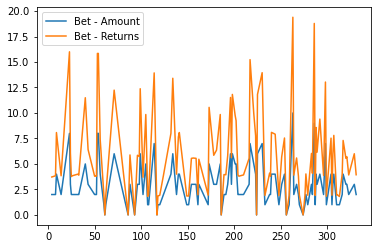

In [1344]:
df_betting[['Bet - Amount', 'Bet - Returns']].plot()

In [645]:
import statsmodels.api as sm
po_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [646]:
goal_model_data['Corners_LAMBDA'] = po_results.mu

In [648]:
goal_model_data['AUX_OLS_DEP']  = goal_model_data.apply(lambda x: ((x['corners'] - x['Corners_LAMBDA'])**2 - x['corners']) / x['Corners_LAMBDA'], axis=1)

In [651]:
ols_expr = """AUX_OLS_DEP ~ Corners_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, goal_model_data).fit()

In [653]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [655]:
def simulate_match(foot_model, homeTeam, awayTeam, max_corners=25):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))


In [1258]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                corners   No. Observations:                47644
Model:                            GLM   Df Residuals:                    46983
Model Family:        NegativeBinomial   Df Model:                          660
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1018e+05
Date:                Fri, 01 Jan 2021   Deviance:                       50610.
Time:                        23:40:12   Pearson chi2:                 4.80e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4291      0.057     25.110      0.000       1.318       1.541
team[T.1016]         0.1501      0.043      3.491      0.000       0.066       0.234
team[T.1025]        -0.1021      0.067     -1.522      0.128      -0.233       0.029
team[T.1026]         0.1952      0.042      4.629      0.000       0.113       0.278
team[T.1028]         0.0605      0.045      1.346      0.178      -0.028       0.149
team[T.1031]        -0.0664      0.052     -1.279      0.201      -0.168       0.035
team[T.1034]        -0.0150      0.045     -0.337      0.736      -0.102       0.072
team[T.1035]         0.1080      0.047      2.299      0.021       0.016       0.200
team[T.1040]         0.1879      0.046      4.048      0.000       0.097       0.279
team[T.1043]         0.1969      0.049      4.033      0.000       0.101       0.293
team[T.1048]        -0.0451      0.068     -0.665      0.506      -0.178       0.088
team[T.1049]         0.1322      0.044      3.007      0.003       0.046       0.218
team[T.1051]         0.0784      0.065      1.210      0.226      -0.049       0.205
team[T.1052]        -0.0870      0.053     -1.626      0.104      -0.192       0.018
team[T.1056]         0.0053      0.046      0.116      0.908      -0.085       0.095
team[T.1061]        -0.0956      0.049     -1.960      0.050      -0.191    1.27e-06
team[T.1071]        -0.0132      0.048     -0.273      0.785      -0.108       0.081
team[T.1072]         0.0504      0.048      1.057      0.291      -0.043       0.144
team[T.1073]         0.3925      0.054      7.256      0.000       0.286       0.498
team[T.1076]        -0.0866      0.064     -1.350      0.177      -0.212       0.039
team[T.1079]        -0.0284      0.050     -0.565      0.572      -0.127       0.070
team[T.1088]         0.0760      0.043      1.747      0.081      -0.009       0.161
team[T.1089]        -0.1331      0.059     -2.260      0.024      -0.249      -0.018
team[T.1090]         0.0623      0.044      1.415      0.157      -0.024       0.149
team[T.1092]         0.1191      0.047      2.549      0.011       0.028       0.211
team[T.1096]        -0.0178      0.049     -0.367      0.714      -0.113       0.077
team[T.1098]         0.0406      0.044      0.915      0.360      -0.046       0.128
team[T.1107]        -0.0373      0.051     -0.738      0.460      -0.137       0.062
team[T.1108]         0.0057      0.057      0.100      0.921      -0.106       0.117
team[T.1116]         0.0715      0.057      1.262      0.207      -0.040       0.183
team[T.1117]         0.1312      0.046      2.855      0.004       0.041       0.221
team[T.1118]         0.3996      0.045      8.795      0.000       0.311       0.489
team[T.1119]        -0.3045      0.111     -2.739      0.006      -0.522      -0.087
team[T.1121]        -0.